# Missing Data Imputation

This module will demonstrate missing data imputation techniques.

Adapted from Jason Brownlee. 2020. [Data Preparation for Machine Learning](https://machinelearningmastery.com/data-preparation-for-machine-learning/).

## Overview

Datasets may have missing values, and this can cause problems for many machine learning
algorithms. As such, it is good practice to identify and replace missing values for each column in
your input data prior to modeling your prediction task. This is called missing data imputation,
or imputing for short.

## Learning Objectives

* Learn how to load a CSV file with missing values and mark the missing values with NaN values
and report the number and percentage of missing values for each column.
* Learn how to impute missing values with statistics as a data preparation method when evaluating models and when fitting a final model to make predictions on new data.
* Learn how to impute missing values with nearest neighbor models as a data preparation method when evaluating models and when fitting a final model to make predictions on new data.
* Learn how to impute missing values with iterative imputation models as a data preparation method when evaluating models and when fitting a final model to make predictions on new data.

### Tasks to complete:

- Load and analyze dataset with missing values
- Implement statistical imputation methods
- Implement k-nearest neighbor imputation
- Implement iterative imputation
- Compare performance of different imputation approaches
- Make predictions with imputed data

## Prerequisites

- Basic understanding of Python programming
- Familiarity with NumPy libraries
- Knowledge of basic statistical concepts

## Get Started

To start, we install required packages and import the necessary libraries.

### Install required packages

In [16]:
# Install matplotlib, numpy, pandas, and scikit-learn libraries using pip package manager.
%pip install matplotlib numpy pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


### Import necessary libraries

In [17]:
# Import the Path class for object-oriented file path manipulation.
from pathlib import Path
# Import the pyplot module from matplotlib for plotting and visualization.
from matplotlib import pyplot
# Import functions from numpy for numerical operations, including handling NaN values and calculating mean and standard deviation.
from numpy import isnan, mean, nan, std
# Import the read_csv function from pandas to read CSV files into DataFrames.
from pandas import read_csv
# Import the RandomForestClassifier class from sklearn.ensemble for building a Random Forest classification model.
from sklearn.ensemble import RandomForestClassifier
# Import the enable_iterative_imputer function to enable experimental iterative imputer in scikit-learn.
from sklearn.experimental import enable_iterative_imputer
# Import the IterativeImputer class for imputing missing values using an iterative approach.
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
# Import classes and functions from sklearn.model_selection for model evaluation, including cross-validation and stratified k-fold.
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
# Import the Pipeline class from sklearn.pipeline to construct a pipeline of data preprocessing and modeling steps.
from sklearn.pipeline import Pipeline

## Hepatitis Dataset

### Overview
The **Hepatitis dataset** is a medical dataset from the UCI Machine Learning Repository. It contains patient data related to hepatitis, which can be used for classification tasks, such as predicting patient survival.

### Data Characteristics
- **Number of Instances:** 155 patients
- **Number of Attributes:** 20 (including the class label)
- **Attribute Types:** Categorical and numerical
- **Missing Values:** Present in some attributes

### Attribute Information
1. **Class (Target Variable)**: Die (1), Live (2)  
2. **Age**: Patient's age in years  
3. **Sex**: Male (1), Female (2)  
4. **Steroid**: Yes (1), No (2)  
5. **Antivirals**: Yes (1), No (2)  
6. **Fatigue**: Yes (1), No (2)  
7. **Malaise**: Yes (1), No (2)  
8. **Anorexia**: Yes (1), No (2)  
9. **Liver Big**: Yes (1), No (2)  
10. **Liver Firm**: Yes (1), No (2)  
11. **Spleen Palpable**: Yes (1), No (2)  
12. **Spiders**: Yes (1), No (2)  
13. **Ascites**: Yes (1), No (2)  
14. **Varices**: Yes (1), No (2)  
15. **Bilirubin**: Continuous (0.39 – 8.0)
16. **Alkaline Phosphatase (ALP)**: Continuous (33 – 250)
17. **SGOT (AST)**: Continuous (13 – 600)
18. **Albumin**: Continuous (2.1 – 6.0)
19. **Protime**: Continuous (10 – 100)
20. **Histology**: Yes (1), No (2)  

### Usage
This dataset is used in medical research and machine learning to study hepatitis progression and survival prediction.

### Source
- UCI Machine Learning Repository: [Hepatitis Dataset](https://archive.ics.uci.edu/dataset/46/hepatitis)

### Loading and summarizing a dataset with missing values.

In [25]:
# Specifies the file path to the hepatitis dataset.
hepatitis_data = "../../Data/hepatitis.data"

# Defines a list of column names for the hepatitis dataset, based on 'hepatitis.names' file.
columns = [
    'class',       # 1=Die, 2=Live (TARGET)
    'age',
    'sex',         # 1=male, 2=female
    'steroid',     # 1=no, 2=yes
    'antivirals',  # 1=no, 2=yes
    'fatigue',
    'malaise',
    'anorexia',
    'liver_big',
    'liver_firm',
    'spleen_palpable',
    'spiders',
    'ascites',
    'varices',
    'bilirubin',
    'alk_phosphate',
    'sgot',
    'albumin',
    'protime',
    'histology'
]

# Loads the hepatitis dataset from the specified file.
df = read_csv(
    hepatitis_data, # Specifies the file path.
    header=None, # Indicates the file has no header row.
    names=columns, # Assigns the defined column names to the DataFrame.
    na_values="?", # Treats '?' as missing values and converts them to NaN.
    sep=',' # Specifies that the data is comma-separated.
)

# Prints a header to indicate the following output is the first 3 rows of the DataFrame.
print("\nFirst 3 rows:")
# Prints the first 3 rows of the DataFrame to display sample data.
print(df.head(3))

# Prints a header to indicate the following output is missing value analysis per column.
print("\nMissing values per column:")
# Iterates through each column name in the 'columns' list.
for col in columns:
    # Calculates the number of missing values (NaN) in the current column.
    n_miss = df[col].isnull().sum()
    # Calculates the percentage of missing values in the current column.
    perc = n_miss / len(df) * 100
    # Prints the column name, the count of missing values, and the percentage of missing values, formatted for readability.
    print(f"> {col:15}: {n_miss:2} ({perc:.1f}%)")


First 3 rows:
   class  age  sex  steroid  antivirals  fatigue  malaise  anorexia  \
0      2   30    2      1.0           2      2.0      2.0       2.0   
1      2   50    1      1.0           2      1.0      2.0       2.0   
2      2   78    1      2.0           2      1.0      2.0       2.0   

   liver_big  liver_firm  spleen_palpable  spiders  ascites  varices  \
0        1.0         2.0              2.0      2.0      2.0      2.0   
1        1.0         2.0              2.0      2.0      2.0      2.0   
2        2.0         2.0              2.0      2.0      2.0      2.0   

   bilirubin  alk_phosphate  sgot  albumin  protime  histology  
0        1.0           85.0  18.0      4.0      NaN          1  
1        0.9          135.0  42.0      3.5      NaN          1  
2        0.7           96.0  32.0      4.0      NaN          1  

Missing values per column:
> class          :  0 (0.0%)
> age            :  0 (0.0%)
> sex            :  0 (0.0%)
> steroid        :  1 (0.6%)
> antiv

### Split data into input and output elements

In [19]:
# Split data (class is first column)
data = df.values
X = data[:, 1:]  # Features (columns 1-19)
y = data[:, 0]    # Target (column 0)

### Define evaluation workflow

In [20]:
# Define a function called 'evaluate_imputation' that takes an imputer object as input.
def evaluate_imputation(imputer):
    # Create a pipeline that first applies the given imputer and then trains a RandomForestClassifier model.
    pipeline = Pipeline(steps=[('imputer', imputer),
                              ('model', RandomForestClassifier())])
    # Define cross-validation strategy using RepeatedStratifiedKFold for robust evaluation.
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # Perform cross-validation using the pipeline, features X, target y, 'accuracy' scoring, and the defined cross-validation strategy.
    scores = cross_val_score(pipeline, X, y, scoring='accuracy',
                            cv=cv, n_jobs=-1)
    # Return the scores obtained from cross-validation.
    return scores

### Test imputation strategies

In [21]:
# Define a dictionary 'strategies' to hold different imputation methods.
strategies = {
    # Key 'Mean': Uses SimpleImputer to replace missing values with the mean of the column.
    'Mean': SimpleImputer(strategy='mean'),
    # Key 'KNN-3': Uses KNNImputer to impute missing values based on 3 nearest neighbors.
    'KNN-3': KNNImputer(n_neighbors=3),
    # Key 'Iterative': Uses IterativeImputer for more complex imputation, allowing up to 10 iterations.
    'Iterative': IterativeImputer(max_iter=10)
}

# Print a header to indicate the start of strategy performance evaluation.
print("\nStrategy Performance:")
# Initialize an empty dictionary 'results' to store the performance scores for each strategy.
results = {}
# Loop through each imputation strategy defined in the 'strategies' dictionary.
for name, imp in strategies.items():
    # Call the function 'evaluate_imputation' (assumed to be defined elsewhere) to evaluate the current imputation strategy 'imp'.
    scores = evaluate_imputation(imp)
    # Store the returned scores in the 'results' dictionary with the strategy 'name' as the key.
    results[name] = scores
    # Print the name of the imputation strategy and its average accuracy and standard deviation (assuming 'scores' is a list of accuracy scores).
    print(f"{name:10} | Accuracy: {mean(scores):.3f} (±{std(scores):.3f})")


Strategy Performance:
Mean       | Accuracy: 0.856 (±0.065)
KNN-3      | Accuracy: 0.850 (±0.059)
Iterative  | Accuracy: 0.876 (±0.072)


### Visualization of impacts of imputation strategies

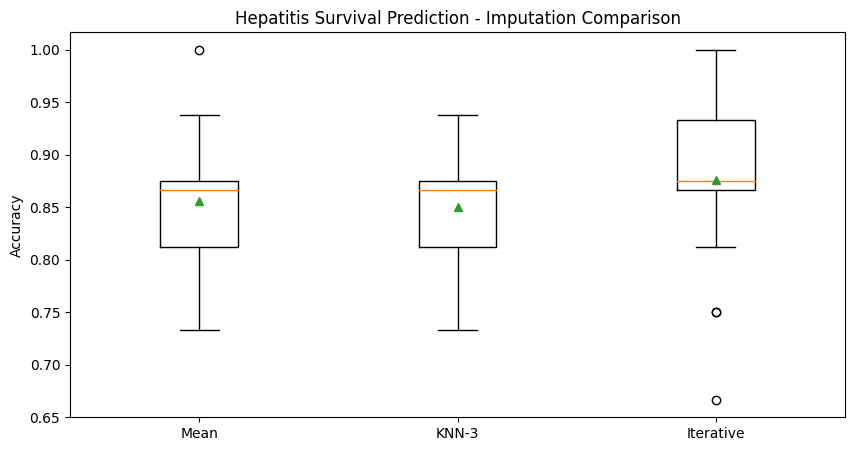

In [22]:
# Visualization
# Create a new figure for plotting with a specified size of 10x5 inches.
pyplot.figure(figsize=(10, 5))
# Generate a boxplot using data from 'results.values()' and labels from 'results.keys()', also display the mean values in the boxplot.
pyplot.boxplot(results.values(), labels=results.keys(), showmeans=True)
# Set the title of the plot to 'Hepatitis Survival Prediction - Imputation Comparison'.
pyplot.title('Hepatitis Survival Prediction - Imputation Comparison')
# Set the label for the y-axis to 'Accuracy'.
pyplot.ylabel('Accuracy')
# Display the generated plot.
pyplot.show()

This analysis compares different imputation methods for handling missing values in the hepatitis dataset and evaluates their impact on model accuracy.

### **Imputation Methods Compared:**
- **Mean Imputation:** Missing values are replaced with the mean of the respective feature.
- **KNN-3 Imputation:** Uses the K-Nearest Neighbors (KNN) method with `k=3` to impute missing values.
- **Iterative Imputation:** Employs an iterative method, such as Multivariate Imputation by Chained Equations (MICE).

### **Box Plot Interpretation:**
- **X-Axis:** Represents different imputation methods.
- **Y-Axis:** Accuracy of the survival prediction model.
- **Box Components:**
  - **Boxes:** Represent the interquartile range (IQR), covering the middle 50% of accuracy values.
  - **Orange Line:** Median accuracy.
  - **Green Triangle:** Mean accuracy.
  - **Whiskers:** Show the spread of data, excluding outliers.
  - **Circles (Outliers):** Unusual values that significantly differ from the rest.

### **Insights:**
- **Mean Imputation:** Shows a relatively stable accuracy distribution with a high median but includes an extreme outlier around **1.0**.
- **KNN-3 Imputation:** Has a broader accuracy range, with a lower minimum accuracy compared to the other methods.
- **Iterative Imputation:** Exhibits the highest median accuracy but also shows more variability with multiple outliers.

The choice of imputation method significantly impacts model performance. The **Iterative approach** provides the best average accuracy but comes with greater variability. The **Mean method** is more stable, making it a safer option if avoiding outliers is a priority.

Further analysis could involve testing additional imputation strategies or tuning hyperparameters for improved performance.


### Prediction example with realistic clinical data

In [24]:
# Define a pipeline for data preprocessing and model training.
best_pipeline = Pipeline(steps=[
    # Step 1: Impute missing values using IterativeImputer with a maximum of 10 iterations.
    ('imputer', IterativeImputer(max_iter=10)),
    # Step 2: Train a RandomForestClassifier model.
    ('model', RandomForestClassifier())
])

# Fit the entire pipeline (imputer and RandomForestClassifier) on the features (X) and target variable (y).
best_pipeline.fit(X, y)

# New patient data with realistic clinical measurements, including missing values represented as 'nan'.
new_patient = [
    34,     # age: 34 years
    2,      # sex: female
    2,      # steroid: yes
    2,      # antivirals: yes
    nan,    # fatigue: missing
    2,      # malaise: yes
    2,      # anorexia: yes
    2,      # liver_big: yes
    2,      # liver_firm: yes
    2,      # spleen_palpable: yes
    2,      # spiders: yes
    nan,    # ascites: missing
    2,      # varices: yes
    1.8,    # bilirubin: 1.8 mg/dl
    nan,    # alk_phosphate: missing
    45,     # sgot: 45 U/ml
    3.2,    # albumin: 3.2 mg/dl
    nan,    # protime: missing
    2       # histology: yes
]

# Predict the outcome (0 or 1) for the new patient using the trained pipeline, passing the new patient's data as a list within a list.
pred = best_pipeline.predict([new_patient])
# Print the predicted outcome, interpreting class 1 as 'Die' and class 0 as 'Live', and also print the raw class prediction (0 or 1).
print(f"\nPredicted Outcome: {'Die' if pred[0] == 1 else 'Live'} (Class: {pred[0]})")


Predicted Outcome: Live (Class: 2.0)


## Conclusion

In this module, we learned several approaches for handling missing data:

- Statistical imputation using mean, median, mode and constant values
- K-nearest neighbor imputation with different numbers of neighbors
- Iterative imputation with different ordering strategies and iterations
- How to properly implement imputation in a machine learning pipeline
- How to evaluate and compare different imputation methods
- How to use imputation when making predictions on new data

## Clean up

Remember to shut down your Jupyter Notebook environment and delete any unnecessary files or resources once you've completed the tutorial.￼